In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

## 1. Data Loading

Load full datasets and compute intersection datasets for all 4 metals.

In [ ]:
# Define metals
metal_names = ['cobalt', 'copper', 'lithium', 'nickel']

# Load full datasets (long horizon)
print("="*60)
print("LOADING FULL DATASETS")
print("="*60 + "\n")

full_data = {}
for metal in metal_names:
    df = pd.read_csv(f'../../data/ALL_{metal}_prices_cubic_spline.csv', 
                     parse_dates=['Date'], index_col='Date')
    full_data[metal.capitalize()] = df
    print(f"{metal.capitalize()} (full): {df.shape[0]} rows, {df.shape[1]} series")
    print(f"  Range: {df.index.min()} to {df.index.max()}")

print("\n" + "="*60)
print("COMPUTING INTERSECTION DATASETS")
print("="*60 + "\n")

# Compute intersection datasets (short horizon)
# Find common time range where ALL series have valid data
intersection_data = {}
for metal in metal_names:
    df = full_data[metal.capitalize()].copy()
    
    # Exclude LISAME series
    if 'LISAME' in df.columns:
        df = df.drop(columns=['LISAME'])
        print(f"{metal.capitalize()}: LISAME series excluded")
    
    # Find the intersection: dates where all series have non-null values
    common_dates = df.dropna().index
    
    if len(common_dates) > 0:
        # Create intersection dataset
        df_int = df.loc[common_dates].copy()
        intersection_data[metal.capitalize()] = df_int
        
        print(f"{metal.capitalize()} (intersection):")
        print(f"  Time range: {df_int.index.min()} to {df_int.index.max()}")
        print(f"  Observations: {len(df_int)}")
        print(f"  Series: {df_int.shape[1]}")
        print(f"  Series names: {df_int.columns.tolist()}")
    else:
        print(f"{metal.capitalize()}: No common intersection found across all series!")
        # Fallback: use most recent common period
        # Find date range with maximum coverage
        coverage = df.notna().sum(axis=1)
        max_coverage = coverage.max()
        best_dates = coverage[coverage == max_coverage].index
        df_int = df.loc[best_dates].dropna(axis=1)  # Keep only complete columns
        intersection_data[metal.capitalize()] = df_int
        
        print(f"  Using fallback: maximum coverage period")
        print(f"  Time range: {df_int.index.min()} to {df_int.index.max()}")
        print(f"  Observations: {len(df_int)}")
        print(f"  Series: {df_int.shape[1]} (some series excluded)")
    
    print()

print("\n" + "="*60)
print("COMPUTING RETURNS")
print("="*60 + "\n")

# Convert prices to returns (not log returns, regular percentage returns)
full_data_returns = {}
for metal in metal_names:
    df = full_data[metal.capitalize()].pct_change().dropna(how='all')
    full_data_returns[metal.capitalize()] = df
    print(f"{metal.capitalize()} returns (full): {df.shape[0]} rows, {df.shape[1]} series")

intersection_data_returns = {}
for metal in metal_names:
    df = intersection_data[metal.capitalize()].pct_change().dropna(how='all')
    intersection_data_returns[metal.capitalize()] = df
    print(f"{metal.capitalize()} returns (intersection): {df.shape[0]} rows, {df.shape[1]} series")

# Replace the original datasets with returns for all subsequent analysis
full_data = full_data_returns
intersection_data = intersection_data_returns

print("\nAll subsequent analysis will use regular returns (pct_change), not log returns.")

LOADING FULL DATASETS

Cobalt (full): 3876 rows, 6 series
  Range: 2012-03-02 00:00:00 to 2025-11-18 00:00:00
Copper (full): 2342 rows, 6 series
  Range: 2017-01-01 00:00:00 to 2025-12-31 00:00:00
Lithium (full): 2202 rows, 7 series
  Range: 2017-05-10 00:00:00 to 2025-12-09 00:00:00
Nickel (full): 2857 rows, 6 series
  Range: 2016-04-04 00:00:00 to 2025-11-18 00:00:00

COMPUTING INTERSECTION DATASETS

Cobalt (intersection):
  Time range: 2023-05-04 00:00:00 to 2025-07-21 00:00:00
  Observations: 662
  Series: 6
  Series names: ['CODALY', 'COLMEX', 'COLMEA', 'COWUXI', 'COCOMX', 'COSMMS']

Copper (intersection):
  Time range: 2024-03-06 00:00:00 to 2025-10-31 00:00:00
  Observations: 432
  Series: 6
  Series names: ['CUDALY', 'CUCOMX', 'CULMEX', 'CUSMMG', 'CUSHFE', 'CUETFC']

Lithium: LISAME series excluded
Lithium (intersection):
  Time range: 2023-10-02 00:00:00 to 2025-10-31 00:00:00
  Observations: 556
  Series: 6
  Series names: ['LIDALY', 'LICOMX', 'LILAMC', 'LIEALC', 'LIEABG', 'L

## 2. Helper Functions

In [3]:
def compute_spearman_matrix(df):
    """Compute Spearman correlation matrix for aligned data."""
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
            else:
                # Remove NaN values for this pair
                valid_idx = df[[col1, col2]].dropna().index
                if len(valid_idx) > 10:  # Minimum 10 observations
                    corr, _ = spearmanr(df.loc[valid_idx, col1], df.loc[valid_idx, col2])
                    corr_matrix.loc[col1, col2] = corr
                else:
                    corr_matrix.loc[col1, col2] = np.nan
    
    return corr_matrix.astype(float)


def compute_pairwise_overlap_corr(df):
    """Compute Spearman correlation for each pair using maximum overlap."""
    corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    overlap_counts = pd.DataFrame(index=df.columns, columns=df.columns, dtype=int)
    
    for col1 in df.columns:
        for col2 in df.columns:
            if col1 == col2:
                corr_matrix.loc[col1, col2] = 1.0
                overlap_counts.loc[col1, col2] = len(df[col1].dropna())
            else:
                # Find overlapping valid data
                valid_idx = df[[col1, col2]].dropna().index
                overlap_counts.loc[col1, col2] = len(valid_idx)
                
                if len(valid_idx) > 10:
                    corr, _ = spearmanr(df.loc[valid_idx, col1], df.loc[valid_idx, col2])
                    corr_matrix.loc[col1, col2] = corr
                else:
                    corr_matrix.loc[col1, col2] = np.nan
    
    return corr_matrix.astype(float), overlap_counts


def create_correlation_network(corr_matrix, title, metal_color):
    """Create network visualization from correlation matrix."""
    G = nx.Graph()
    
    # Add nodes
    for node in corr_matrix.columns:
        G.add_node(node)
    
    # Add edges for all correlations (no threshold)
    edge_colors = []
    edge_widths = []
    
    for i, col1 in enumerate(corr_matrix.columns):
        for col2 in corr_matrix.columns[i+1:]:
            corr = corr_matrix.loc[col1, col2]
            if pd.notna(corr):
                G.add_edge(col1, col2, weight=abs(corr), corr=corr)
                
                # Color: green for positive, red for negative
                if corr > 0:
                    edge_colors.append('#27ae60')
                else:
                    edge_colors.append('#e74c3c')
                
                edge_widths.append(abs(corr) ** 1.5 * 8)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 12))
    
    if G.number_of_nodes() > 0:
        if G.number_of_edges() > 0:
            pos = nx.spring_layout(G, k=2, iterations=100, seed=42, weight='weight')
        else:
            # No edges - use circular layout for nodes only
            pos = nx.circular_layout(G)
            print(f"  WARNING: No valid correlations - showing nodes only")
        
        # Draw edges (if any)
        if G.number_of_edges() > 0:
            nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color=edge_colors)
        
        # Draw nodes (always show nodes)
        nx.draw_networkx_nodes(G, pos, node_color=metal_color, 
                              node_size=1200, alpha=0.9, linewidths=2.5, edgecolors='white')
        
        # Add labels
        nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold',
                               font_color='black', bbox=dict(boxstyle='round,pad=0.2',
                               facecolor='white', edgecolor='none', alpha=0.7))
        
        # Legend (only if edges exist)
        if G.number_of_edges() > 0:
            legend_elements = [
                plt.Line2D([0], [0], color='#27ae60', linewidth=3, label='Positive correlation'),
                plt.Line2D([0], [0], color='#e74c3c', linewidth=3, label='Negative correlation')
            ]
            ax.legend(handles=legend_elements, loc='upper right', fontsize=11, framealpha=0.95)
    else:
        print(f"  WARNING: No data to visualize")
    
    plt.title(title, fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return G

## 3. Analysis by Metal

For each metal, compare short horizon (intersection-based) vs long horizon (pairwise overlap).

### 3.1 Cobalt

In [4]:
metal = 'Cobalt'
color = '#3498db'  # Blue

print(f"{'='*60}")
print(f"  {metal.upper()} - CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Short horizon (intersection)
print("SHORT HORIZON (Intersection-based)")
print("-" * 40)
df_short = intersection_data[metal].dropna()
print(f"Time range: {df_short.index.min()} to {df_short.index.max()}")
print(f"Observations: {len(df_short)}")
print(f"Series: {df_short.columns.tolist()}\n")

corr_short = compute_spearman_matrix(df_short)
print("Spearman correlation matrix (short horizon):")
print(corr_short.round(3))
print(f"\nMean correlation: {corr_short.values[np.triu_indices_from(corr_short.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_short.values[np.triu_indices_from(corr_short.values, k=1)]):.3f}\n")

# Long horizon (pairwise overlap)
print("LONG HORIZON (Pairwise overlap)")
print("-" * 40)
df_long = full_data[metal]
print(f"Full dataset range: {df_long.index.min()} to {df_long.index.max()}")
print(f"Total rows: {len(df_long)}\n")

corr_long, overlap_counts = compute_pairwise_overlap_corr(df_long)
print("Spearman correlation matrix (long horizon - pairwise overlap):")
print(corr_long.round(3))
print(f"\nMean correlation: {corr_long.values[np.triu_indices_from(corr_long.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_long.values[np.triu_indices_from(corr_long.values, k=1)]):.3f}")

print("\nOverlap counts (observations per pair):")
print(overlap_counts)

  COBALT - CORRELATION ANALYSIS

SHORT HORIZON (Intersection-based)
----------------------------------------
Time range: 2023-05-05 00:00:00 to 2025-07-21 00:00:00
Observations: 661
Series: ['CODALY', 'COLMEX', 'COLMEA', 'COWUXI', 'COCOMX', 'COSMMS']

Spearman correlation matrix (short horizon):
        CODALY  COLMEX  COLMEA  COWUXI  COCOMX  COSMMS
CODALY   1.000   0.215   0.014   0.061   0.063   0.151
COLMEX   0.215   1.000   0.087   0.084   0.043   0.056
COLMEA   0.014   0.087   1.000   0.015  -0.082  -0.007
COWUXI   0.061   0.084   0.015   1.000   0.068   0.111
COCOMX   0.063   0.043  -0.082   0.068   1.000   0.100
COSMMS   0.151   0.056  -0.007   0.111   0.100   1.000

Mean correlation: 0.065
Median correlation: 0.063

LONG HORIZON (Pairwise overlap)
----------------------------------------
Full dataset range: 2012-03-05 00:00:00 to 2025-11-18 00:00:00
Total rows: 3875

Spearman correlation matrix (long horizon - pairwise overlap):
        CODALY  COLMEX  COLMEA  COWUXI  COCOMX  C


COBALT VISUALIZATIONS



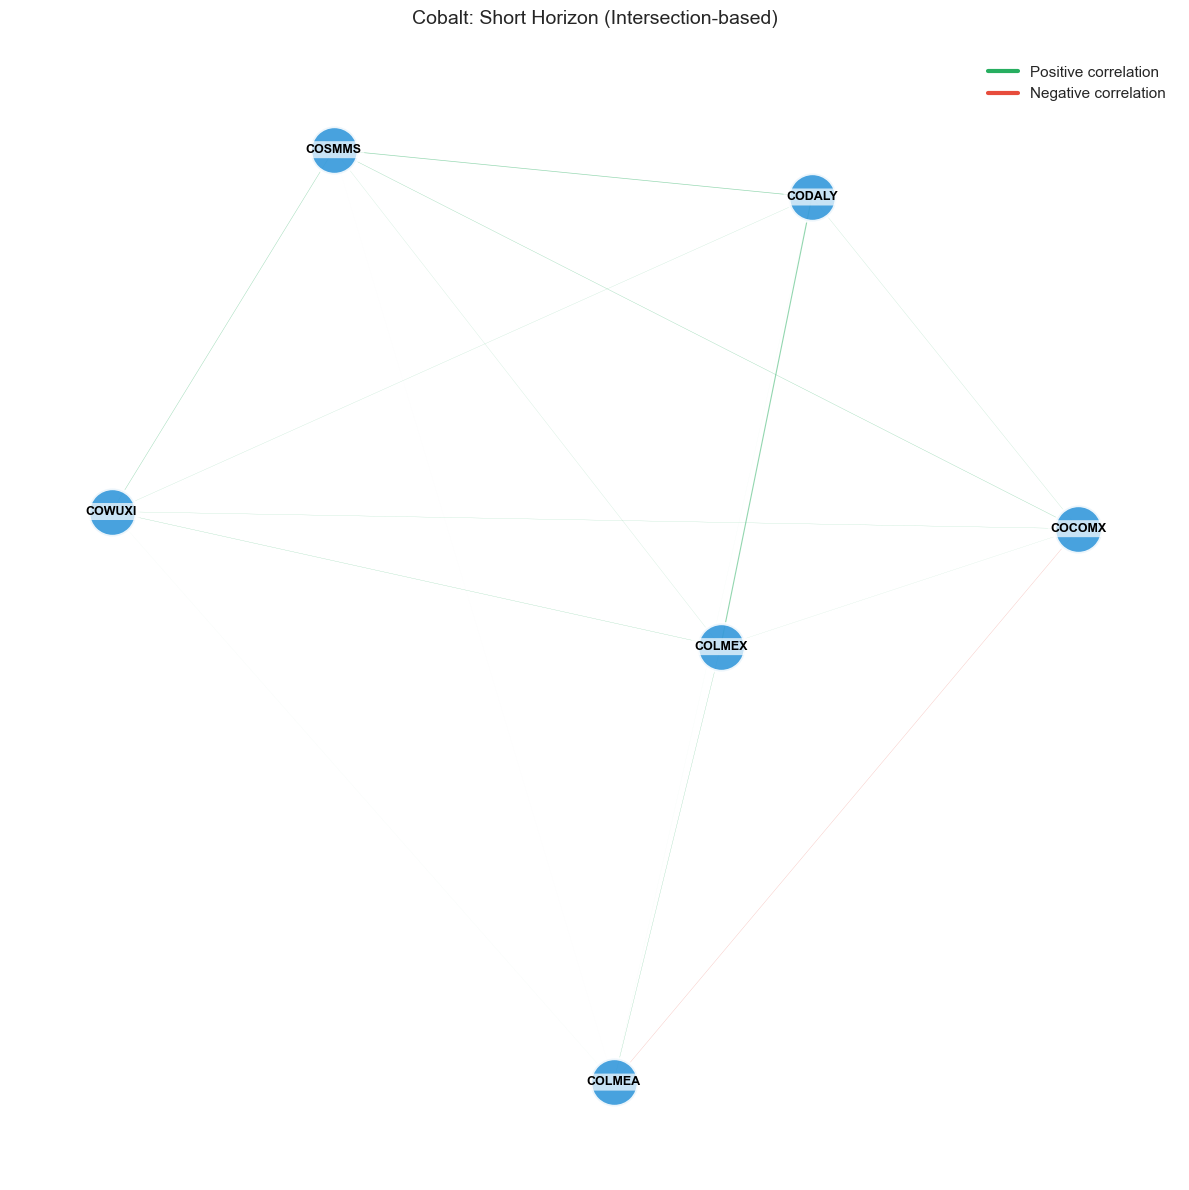

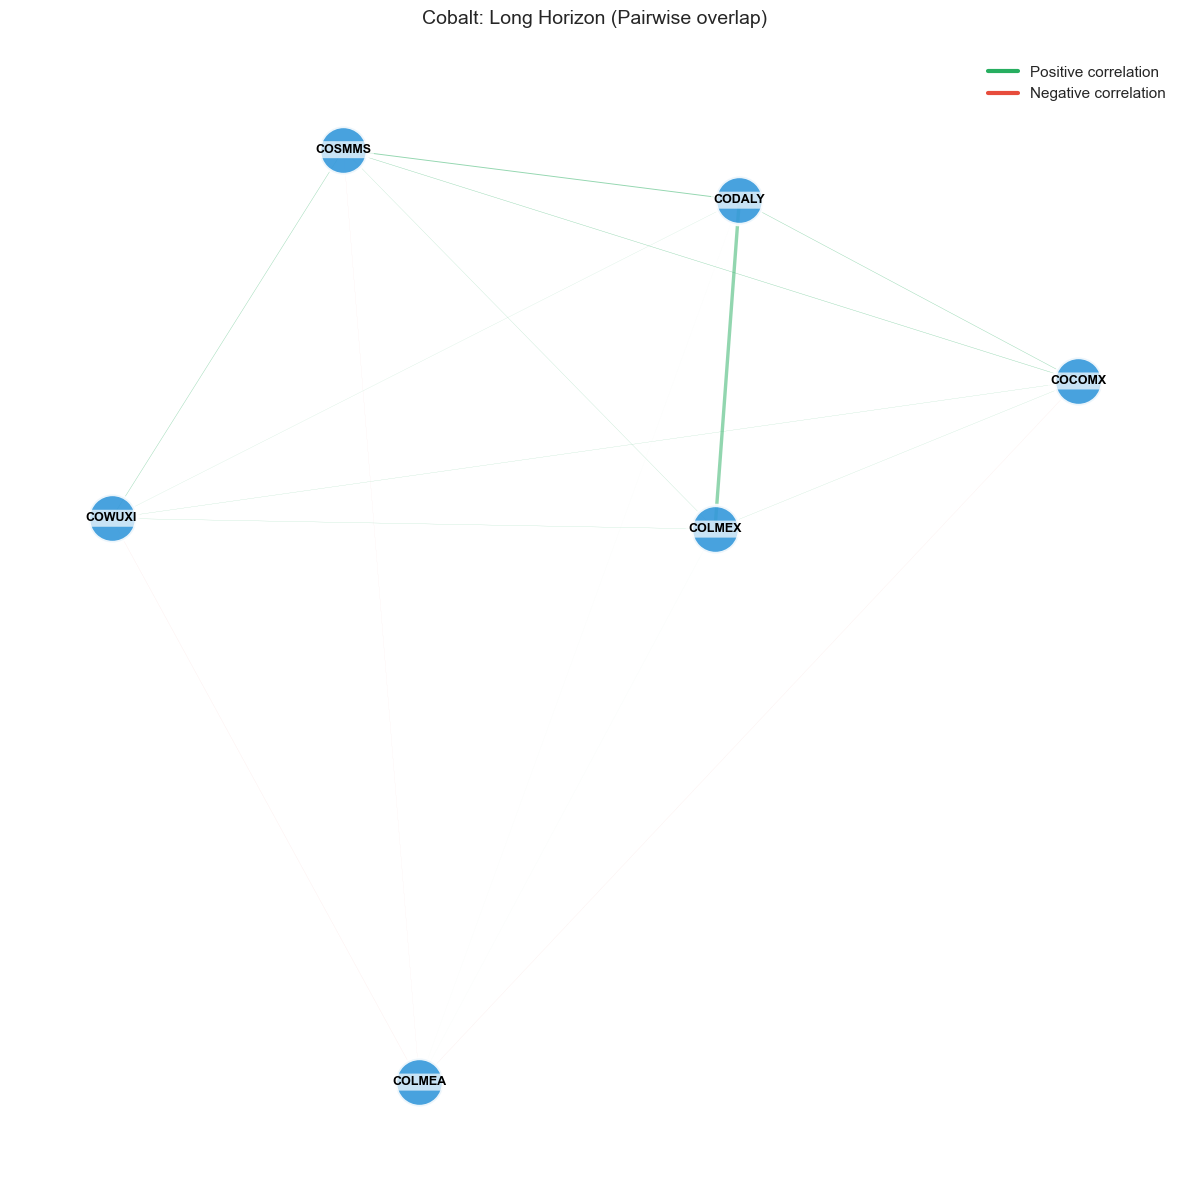

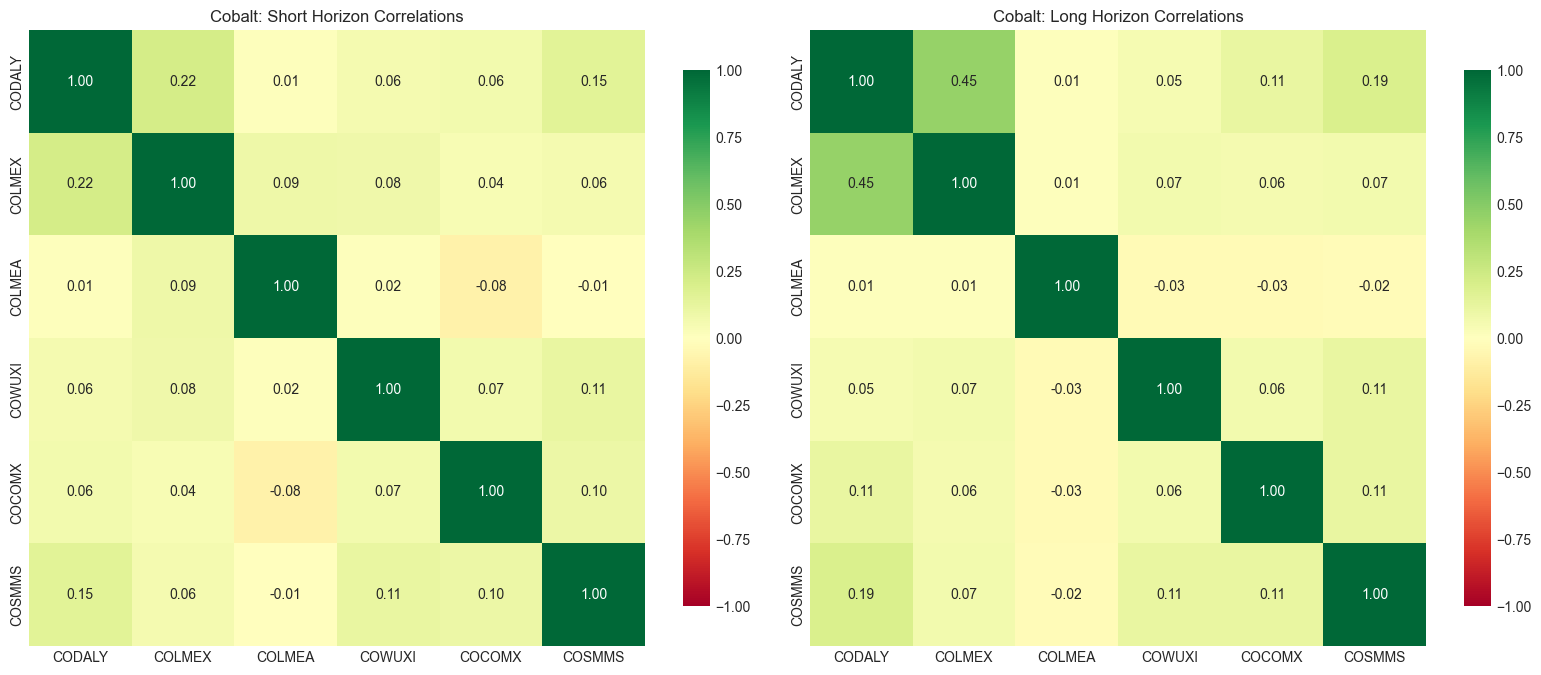

In [5]:
# Visualizations for Cobalt
print("\n" + "="*60)
print("COBALT VISUALIZATIONS")
print("="*60 + "\n")

G_short = create_correlation_network(corr_short, 
                                     f'{metal}: Short Horizon (Intersection-based)',
                                     color)

G_long = create_correlation_network(corr_long,
                                    f'{metal}: Long Horizon (Pairwise overlap)',
                                    color)

# Comparison heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_short, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'{metal}: Short Horizon Correlations', fontsize=12)

sns.heatmap(corr_long, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'{metal}: Long Horizon Correlations', fontsize=12)

plt.tight_layout()
plt.show()

### 3.2 Copper

In [6]:
metal = 'Copper'
color = '#e67e22'  # Orange

print(f"{'='*60}")
print(f"  {metal.upper()} - CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Short horizon
print("SHORT HORIZON (Intersection-based)")
print("-" * 40)
df_short = intersection_data[metal].dropna()
print(f"Time range: {df_short.index.min()} to {df_short.index.max()}")
print(f"Observations: {len(df_short)}")
print(f"Series: {df_short.columns.tolist()}\n")

corr_short = compute_spearman_matrix(df_short)
print("Spearman correlation matrix (short horizon):")
print(corr_short.round(3))
print(f"\nMean correlation: {corr_short.values[np.triu_indices_from(corr_short.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_short.values[np.triu_indices_from(corr_short.values, k=1)]):.3f}\n")

# Long horizon
print("LONG HORIZON (Pairwise overlap)")
print("-" * 40)
df_long = full_data[metal]
print(f"Full dataset range: {df_long.index.min()} to {df_long.index.max()}")
print(f"Total rows: {len(df_long)}\n")

corr_long, overlap_counts = compute_pairwise_overlap_corr(df_long)
print("Spearman correlation matrix (long horizon - pairwise overlap):")
print(corr_long.round(3))
print(f"\nMean correlation: {corr_long.values[np.triu_indices_from(corr_long.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_long.values[np.triu_indices_from(corr_long.values, k=1)]):.3f}")

print("\nOverlap counts (observations per pair):")
print(overlap_counts)

  COPPER - CORRELATION ANALYSIS

SHORT HORIZON (Intersection-based)
----------------------------------------
Time range: 2024-03-07 00:00:00 to 2025-10-31 00:00:00
Observations: 431
Series: ['CUDALY', 'CUCOMX', 'CULMEX', 'CUSMMG', 'CUSHFE', 'CUETFC']

Spearman correlation matrix (short horizon):
        CUDALY  CUCOMX  CULMEX  CUSMMG  CUSHFE  CUETFC
CUDALY   1.000   0.921   0.785   0.123   0.135   0.671
CUCOMX   0.921   1.000   0.797   0.150   0.156   0.667
CULMEX   0.785   0.797   1.000   0.177   0.174   0.644
CUSMMG   0.123   0.150   0.177   1.000   0.919   0.094
CUSHFE   0.135   0.156   0.174   0.919   1.000   0.127
CUETFC   0.671   0.667   0.644   0.094   0.127   1.000

Mean correlation: 0.436
Median correlation: 0.177

LONG HORIZON (Pairwise overlap)
----------------------------------------
Full dataset range: 2017-01-03 00:00:00 to 2025-12-31 00:00:00
Total rows: 2341

Spearman correlation matrix (long horizon - pairwise overlap):
        CUDALY  CUCOMX  CULMEX  CUSMMG  CUSHFE  C


COPPER VISUALIZATIONS



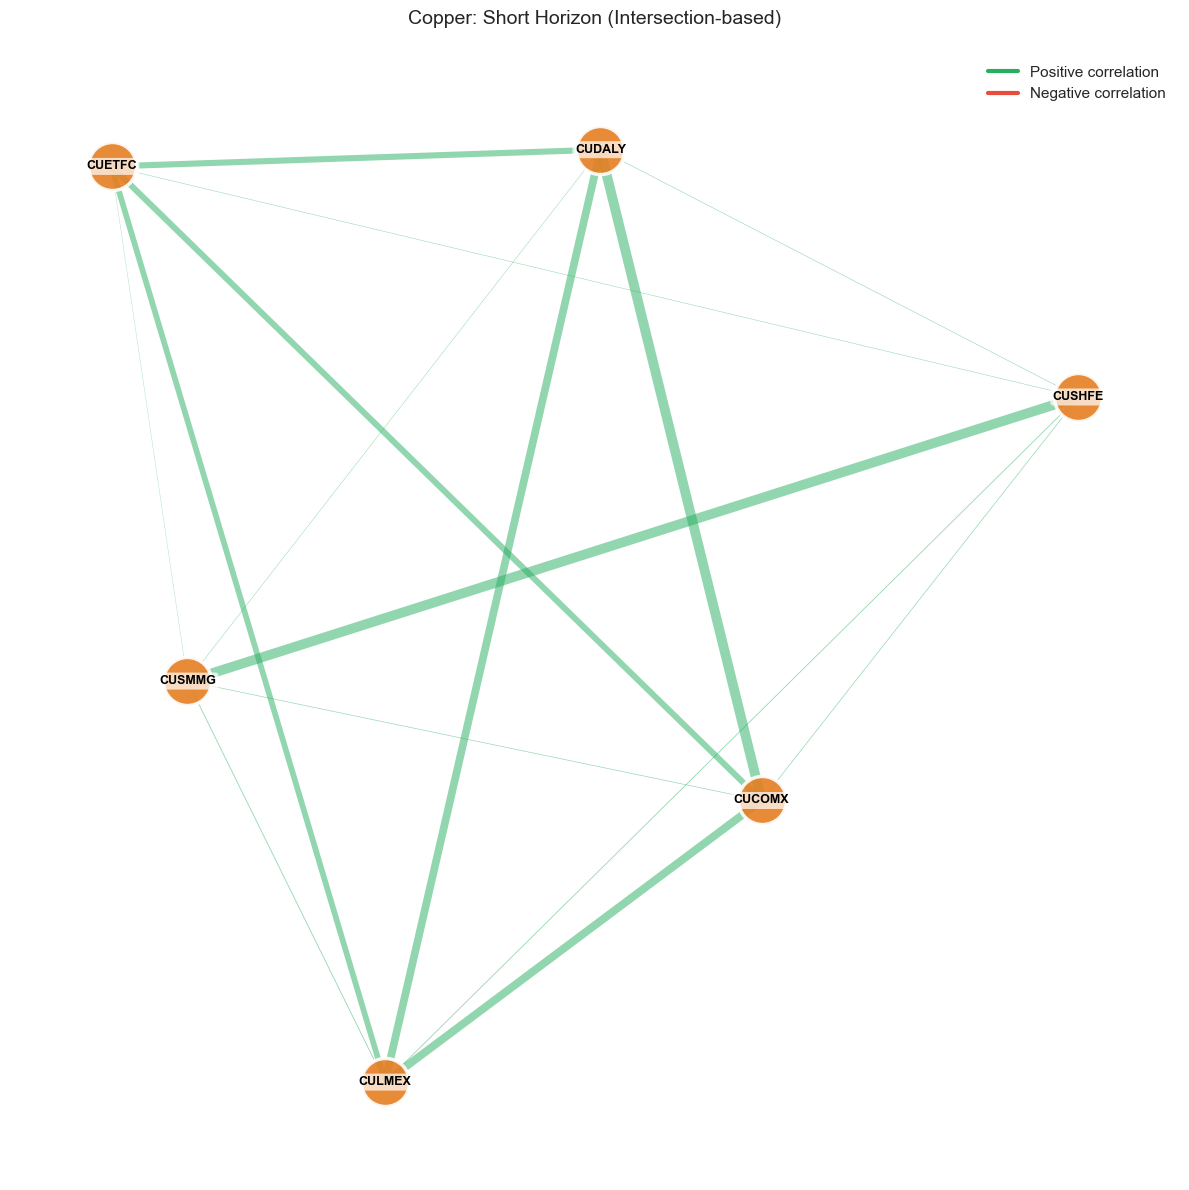

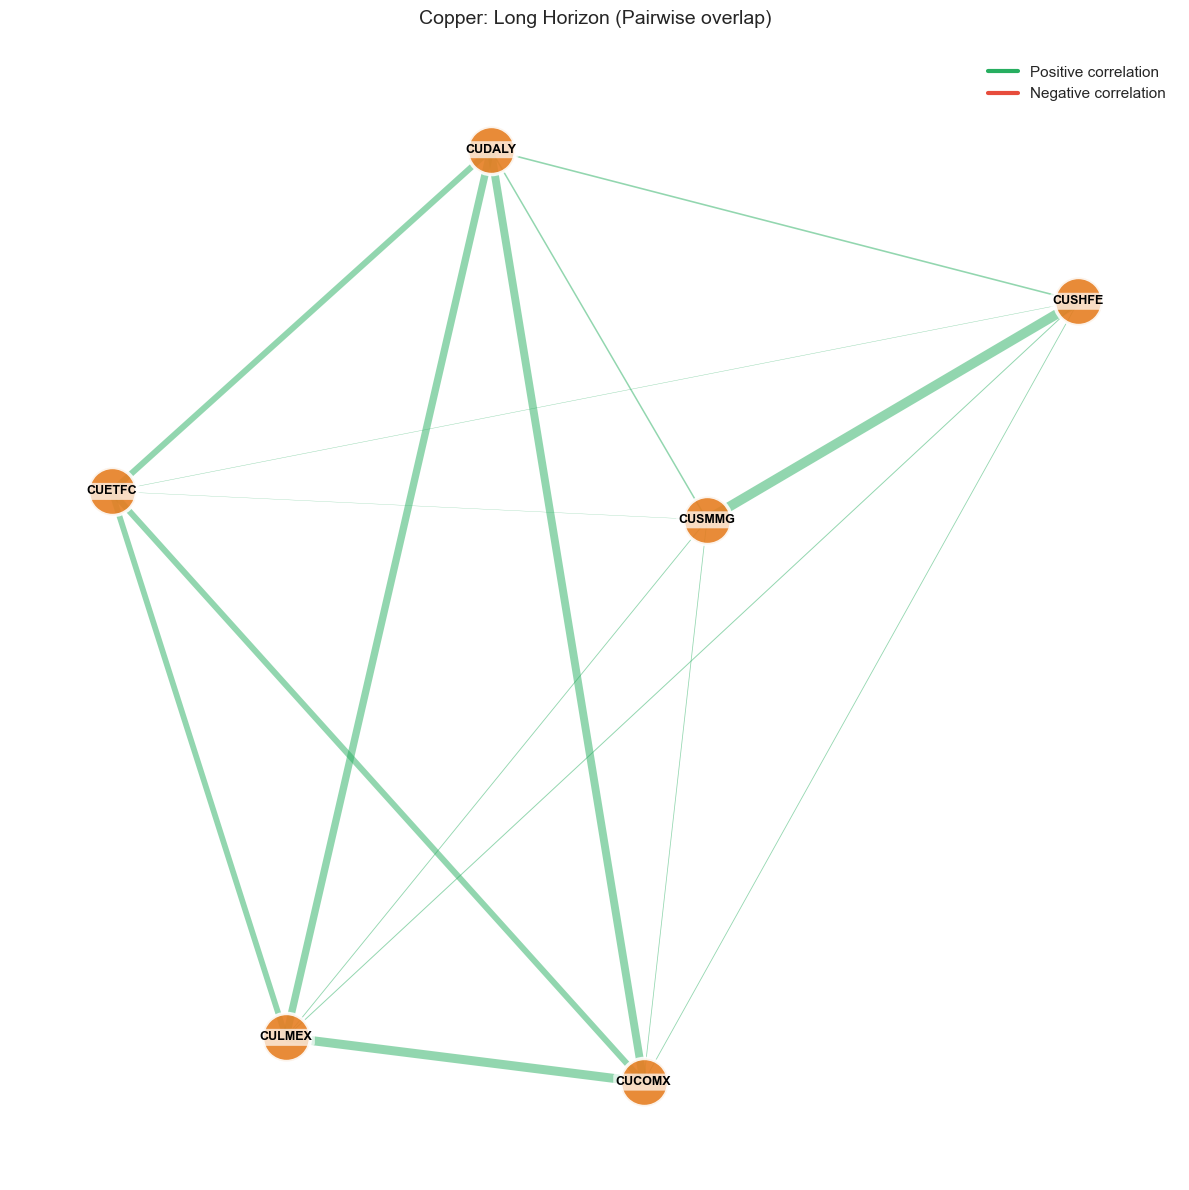

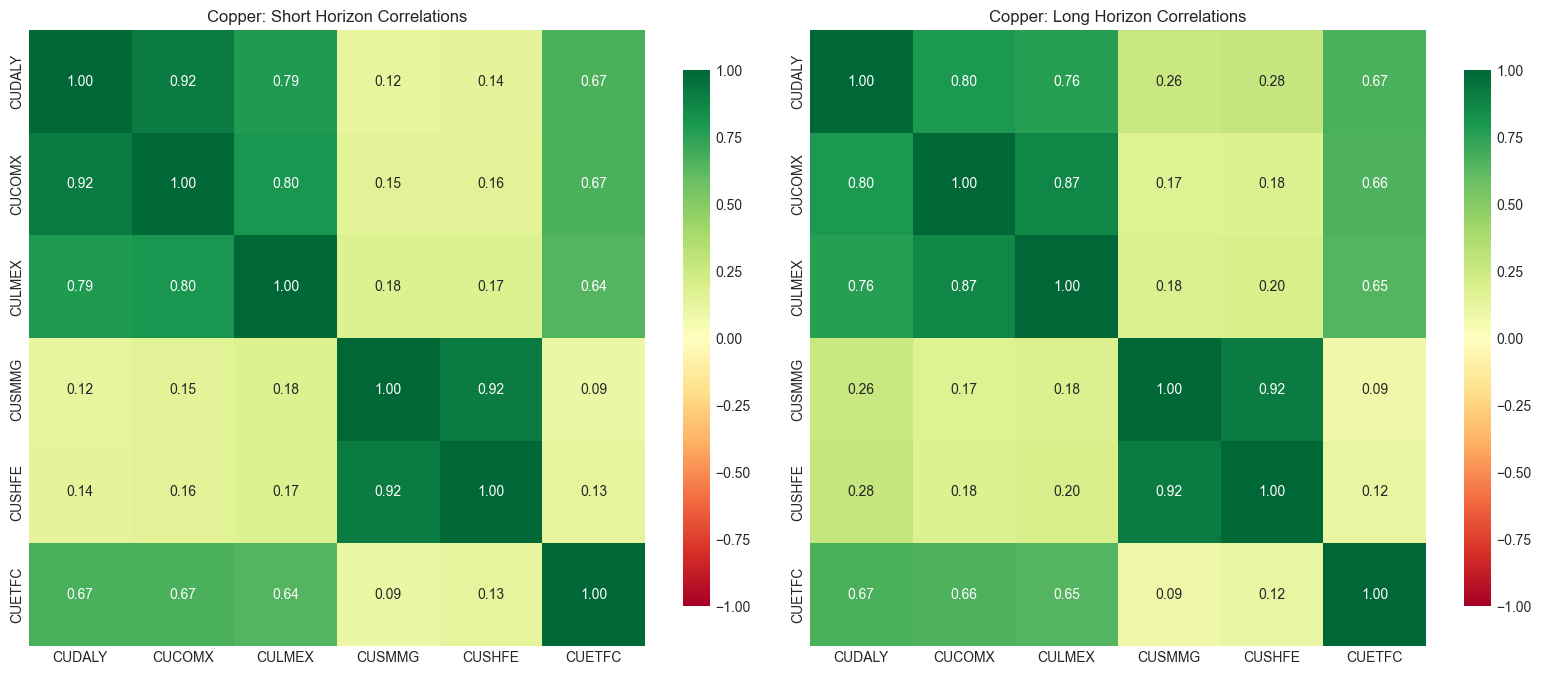

In [7]:
# Visualizations for Copper
print("\n" + "="*60)
print("COPPER VISUALIZATIONS")
print("="*60 + "\n")

G_short = create_correlation_network(corr_short,
                                     f'{metal}: Short Horizon (Intersection-based)',
                                     color)

G_long = create_correlation_network(corr_long,
                                    f'{metal}: Long Horizon (Pairwise overlap)',
                                    color)

# Comparison heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_short, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'{metal}: Short Horizon Correlations', fontsize=12)

sns.heatmap(corr_long, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'{metal}: Long Horizon Correlations', fontsize=12)

plt.tight_layout()
plt.show()

### 3.3 Lithium

In [8]:
metal = 'Lithium'
color = '#27ae60'  # Green

print(f"{'='*60}")
print(f"  {metal.upper()} - CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Short horizon
print("SHORT HORIZON (Intersection-based)")
print("-" * 40)
df_short = intersection_data[metal].dropna()
print(f"Time range: {df_short.index.min()} to {df_short.index.max()}")
print(f"Observations: {len(df_short)}")
print(f"Series: {df_short.columns.tolist()}\n")

corr_short = compute_spearman_matrix(df_short)
print("Spearman correlation matrix (short horizon):")
print(corr_short.round(3))
print(f"\nMean correlation: {corr_short.values[np.triu_indices_from(corr_short.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_short.values[np.triu_indices_from(corr_short.values, k=1)]):.3f}\n")

# Long horizon
print("LONG HORIZON (Pairwise overlap)")
print("-" * 40)
df_long = full_data[metal]
print(f"Full dataset range: {df_long.index.min()} to {df_long.index.max()}")
print(f"Total rows: {len(df_long)}\n")

corr_long, overlap_counts = compute_pairwise_overlap_corr(df_long)
print("Spearman correlation matrix (long horizon - pairwise overlap):")
print(corr_long.round(3))
print(f"\nMean correlation: {corr_long.values[np.triu_indices_from(corr_long.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_long.values[np.triu_indices_from(corr_long.values, k=1)]):.3f}")

print("\nOverlap counts (observations per pair):")
print(overlap_counts)

  LITHIUM - CORRELATION ANALYSIS

SHORT HORIZON (Intersection-based)
----------------------------------------
Time range: 2023-10-03 00:00:00 to 2025-10-31 00:00:00
Observations: 555
Series: ['LIDALY', 'LICOMX', 'LILAMC', 'LIEALC', 'LIEABG', 'LILMEX']

Spearman correlation matrix (short horizon):
        LIDALY  LICOMX  LILAMC  LIEALC  LIEABG  LILMEX
LIDALY   1.000   0.018   0.019   0.179   0.227   0.080
LICOMX   0.018   1.000   0.032   0.046   0.023   0.139
LILAMC   0.019   0.032   1.000   0.050   0.089   0.002
LIEALC   0.179   0.046   0.050   1.000   0.149  -0.011
LIEABG   0.227   0.023   0.089   0.149   1.000   0.020
LILMEX   0.080   0.139   0.002  -0.011   0.020   1.000

Mean correlation: 0.071
Median correlation: 0.046

LONG HORIZON (Pairwise overlap)
----------------------------------------
Full dataset range: 2017-05-11 00:00:00 to 2025-12-09 00:00:00
Total rows: 2201

Spearman correlation matrix (long horizon - pairwise overlap):
        LIDALY  LISAME  LICOMX  LILAMC  LIEALC  


LITHIUM VISUALIZATIONS



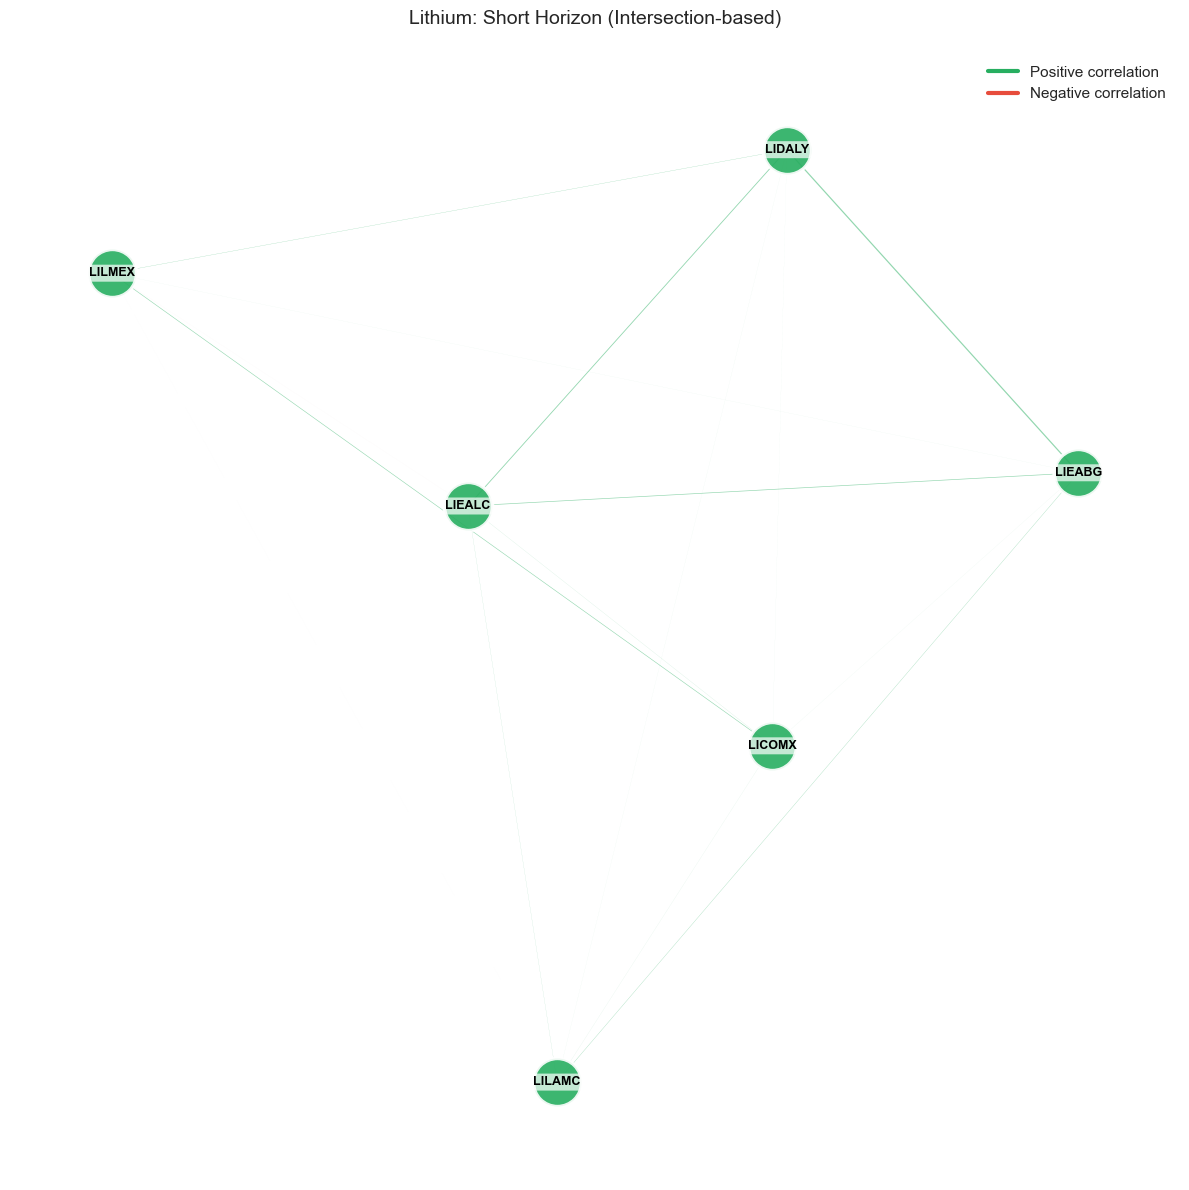

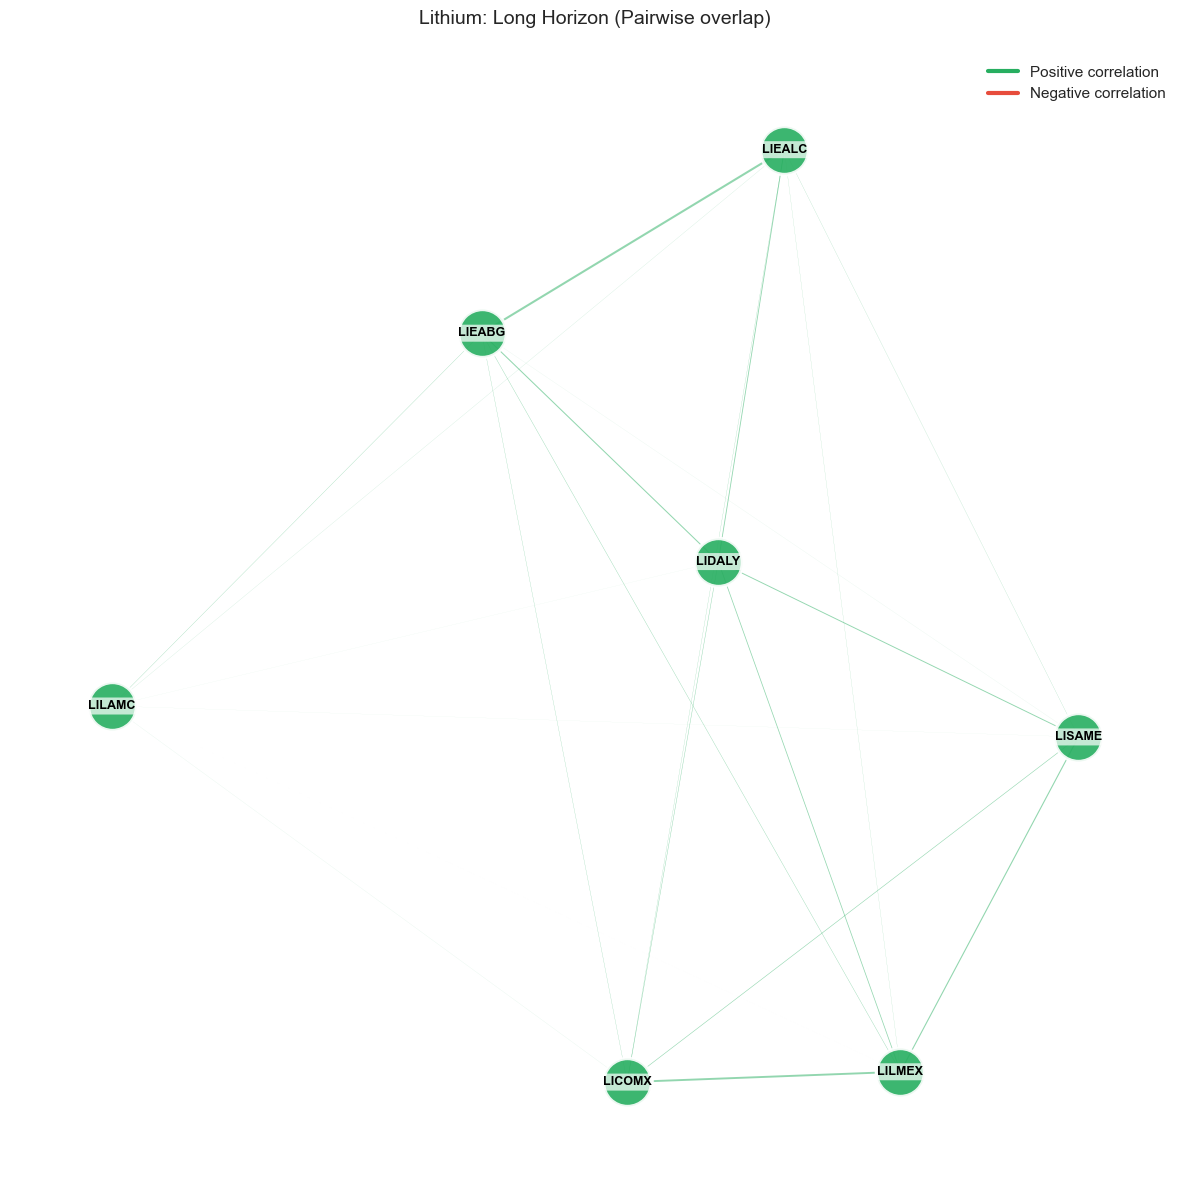

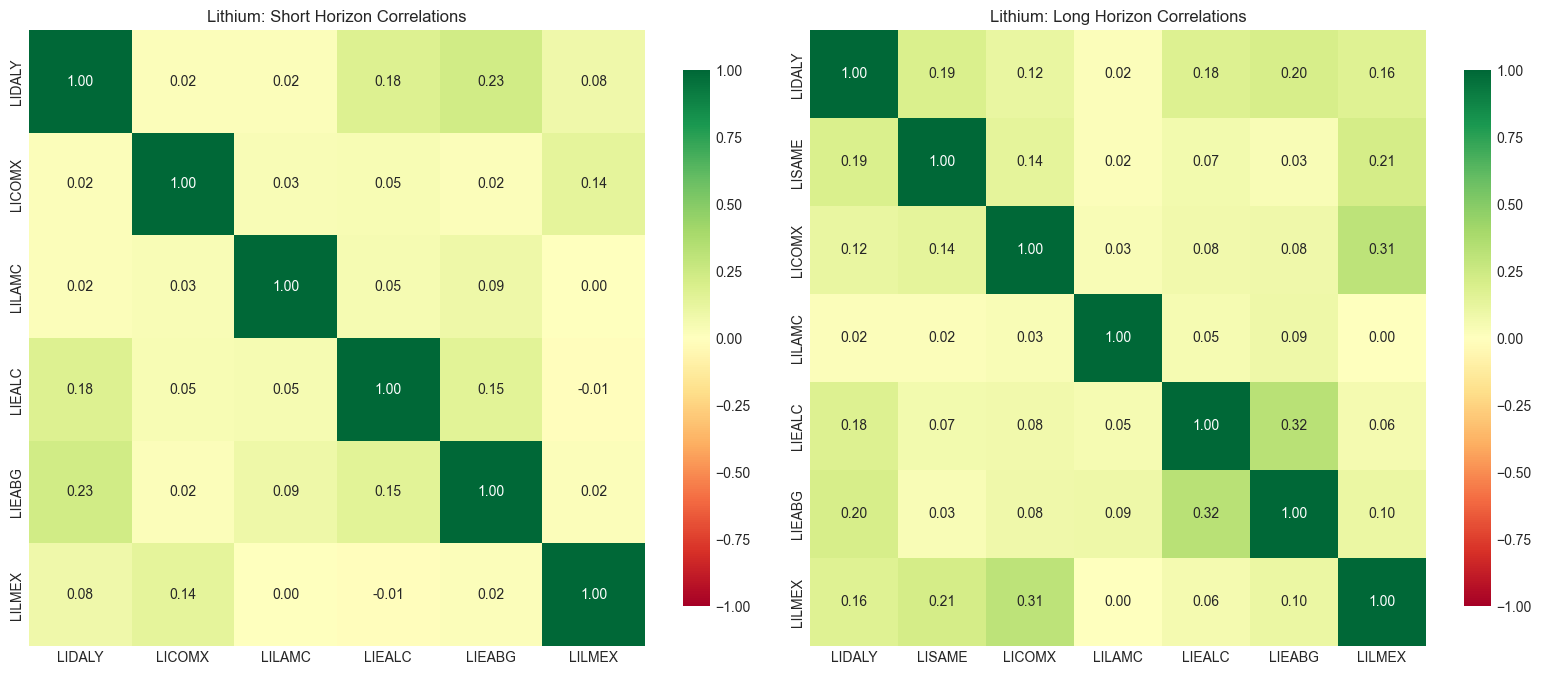

In [9]:
# Visualizations for Lithium
print("\n" + "="*60)
print("LITHIUM VISUALIZATIONS")
print("="*60 + "\n")

G_short = create_correlation_network(corr_short,
                                     f'{metal}: Short Horizon (Intersection-based)',
                                     color)

G_long = create_correlation_network(corr_long,
                                    f'{metal}: Long Horizon (Pairwise overlap)',
                                    color)

# Comparison heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_short, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'{metal}: Short Horizon Correlations', fontsize=12)

sns.heatmap(corr_long, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'{metal}: Long Horizon Correlations', fontsize=12)

plt.tight_layout()
plt.show()

### 3.4 Nickel

In [10]:
metal = 'Nickel'
color = '#9b59b6'  # Purple

print(f"{'='*60}")
print(f"  {metal.upper()} - CORRELATION ANALYSIS")
print(f"{'='*60}\n")

# Short horizon
print("SHORT HORIZON (Intersection-based)")
print("-" * 40)
df_short = intersection_data[metal].dropna()
print(f"Time range: {df_short.index.min()} to {df_short.index.max()}")
print(f"Observations: {len(df_short)}")
print(f"Series: {df_short.columns.tolist()}\n")

corr_short = compute_spearman_matrix(df_short)
print("Spearman correlation matrix (short horizon):")
print(corr_short.round(3))
print(f"\nMean correlation: {corr_short.values[np.triu_indices_from(corr_short.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_short.values[np.triu_indices_from(corr_short.values, k=1)]):.3f}\n")

# Long horizon
print("LONG HORIZON (Pairwise overlap)")
print("-" * 40)
df_long = full_data[metal]
print(f"Full dataset range: {df_long.index.min()} to {df_long.index.max()}")
print(f"Total rows: {len(df_long)}\n")

corr_long, overlap_counts = compute_pairwise_overlap_corr(df_long)
print("Spearman correlation matrix (long horizon - pairwise overlap):")
print(corr_long.round(3))
print(f"\nMean correlation: {corr_long.values[np.triu_indices_from(corr_long.values, k=1)].mean():.3f}")
print(f"Median correlation: {np.median(corr_long.values[np.triu_indices_from(corr_long.values, k=1)]):.3f}")

print("\nOverlap counts (observations per pair):")
print(overlap_counts)

  NICKEL - CORRELATION ANALYSIS

SHORT HORIZON (Intersection-based)
----------------------------------------
Time range: 2023-03-23 00:00:00 to 2025-07-21 00:00:00
Observations: 697
Series: ['NIDALY', 'NILMEX', 'NIETFN', 'NISHFE', 'NIWUXI', 'NIINDA']

Spearman correlation matrix (short horizon):
        NIDALY  NILMEX  NIETFN  NISHFE  NIWUXI  NIINDA
NIDALY   1.000   0.855   0.221   0.153   0.635   0.004
NILMEX   0.855   1.000   0.246   0.133   0.710  -0.026
NIETFN   0.221   0.246   1.000   0.139   0.208   0.076
NISHFE   0.153   0.133   0.139   1.000   0.213   0.264
NIWUXI   0.635   0.710   0.208   0.213   1.000  -0.004
NIINDA   0.004  -0.026   0.076   0.264  -0.004   1.000

Mean correlation: 0.255
Median correlation: 0.208

LONG HORIZON (Pairwise overlap)
----------------------------------------
Full dataset range: 2016-04-05 00:00:00 to 2025-11-18 00:00:00
Total rows: 2856

Spearman correlation matrix (long horizon - pairwise overlap):
        NIDALY  NILMEX  NIETFN  NISHFE  NIWUXI  N


NICKEL VISUALIZATIONS



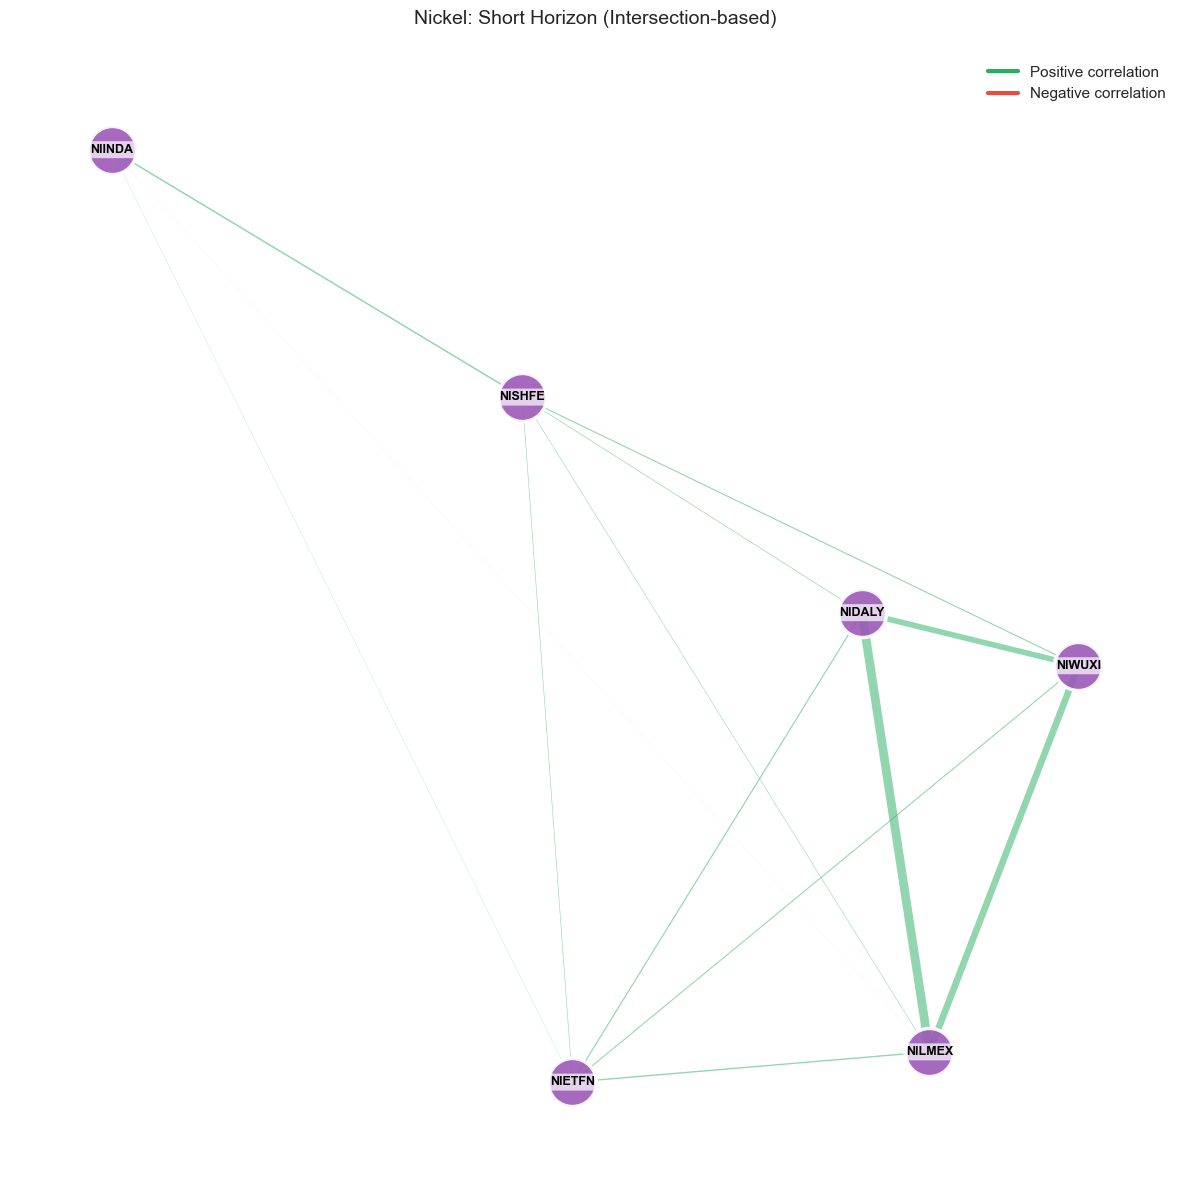

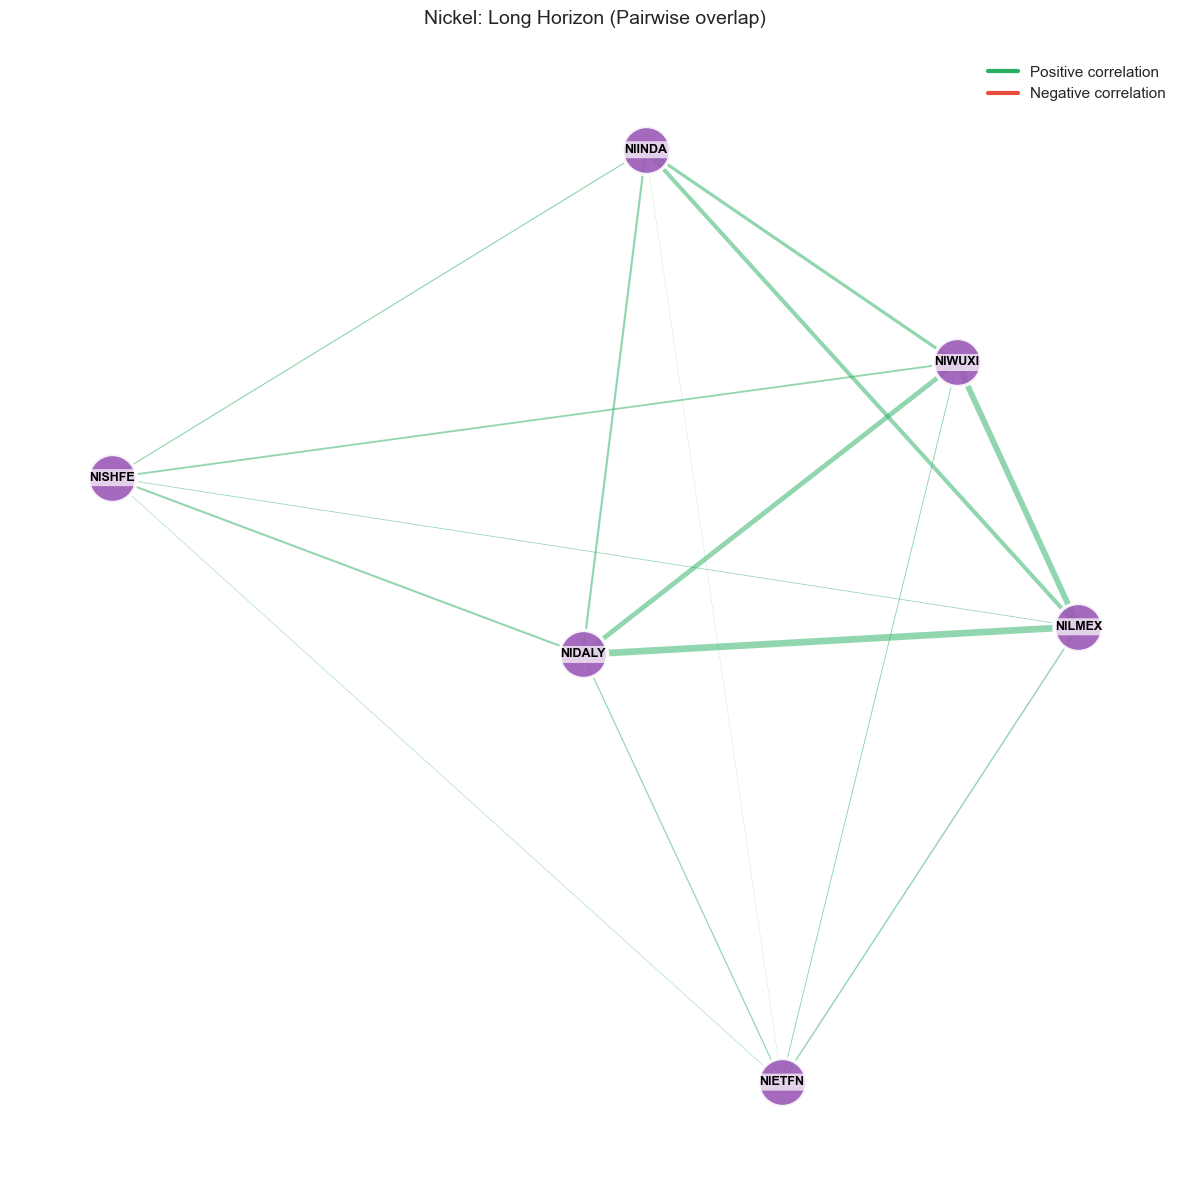

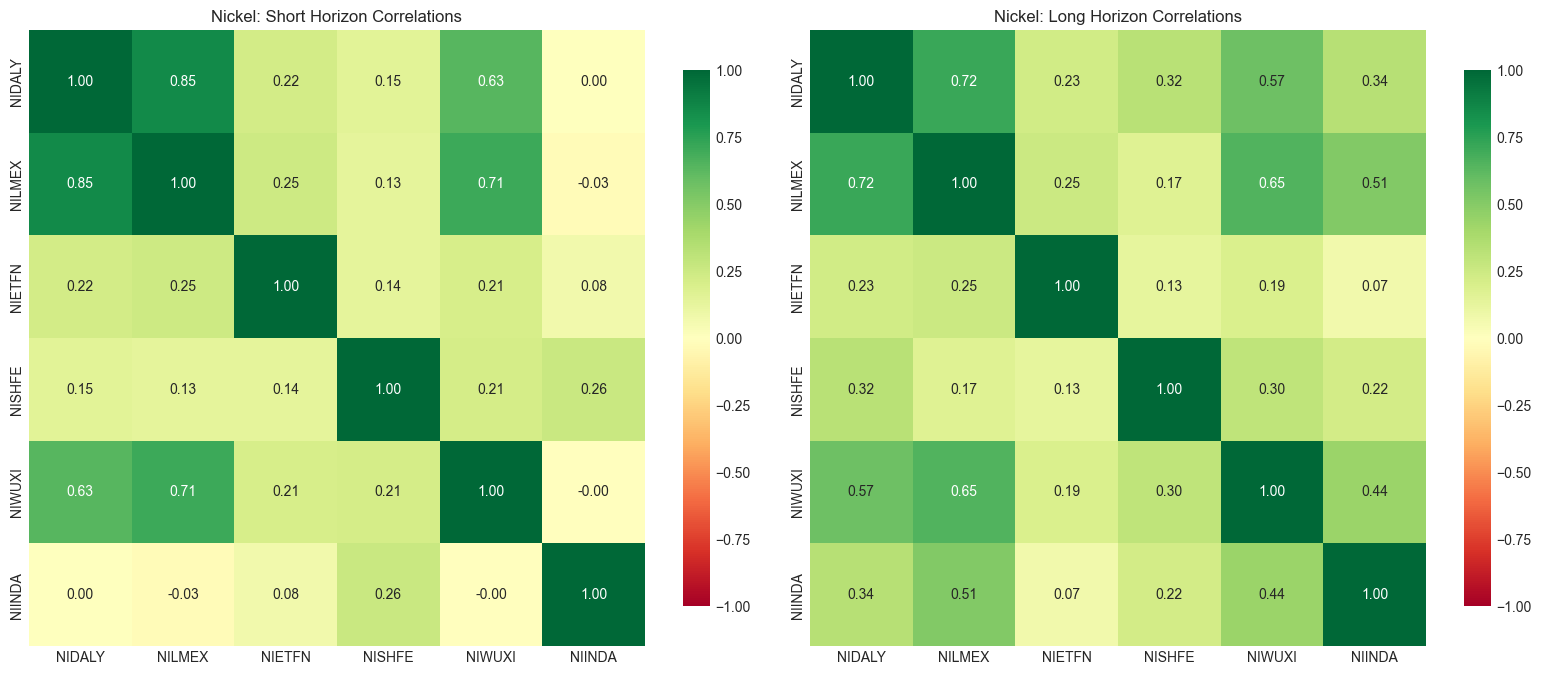

In [12]:
# Visualizations for Nickel
print("\n" + "="*60)
print("NICKEL VISUALIZATIONS")
print("="*60 + "\n")

G_short = create_correlation_network(corr_short,
                                     f'{metal}: Short Horizon (Intersection-based)',
                                     color)

G_long = create_correlation_network(corr_long,
                                    f'{metal}: Long Horizon (Pairwise overlap)',
                                    color)
# Comparison heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(corr_short, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[0], cbar_kws={"shrink": 0.8})
axes[0].set_title(f'{metal}: Short Horizon Correlations', fontsize=12)

sns.heatmap(corr_long, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            vmin=-1, vmax=1, square=True, ax=axes[1], cbar_kws={"shrink": 0.8})
axes[1].set_title(f'{metal}: Long Horizon Correlations', fontsize=12)

plt.tight_layout()
plt.show()

## 4. Key Insights

**Time Horizon Effects:**

1. **Short horizon (intersection-based)**:
   - Uses only the common time period where all series overlap
   - May have fewer observations but ensures temporal alignment
   - Reflects correlation structure during the shared period
   - More suitable for comparing contemporaneous relationships

2. **Long horizon (pairwise overlap)**:
   - Maximizes data usage by using full overlap for each pair
   - Different pairs may be correlated over different time periods
   - Can capture longer-term relationships
   - May include different market regimes for different pairs

**Expected Differences:**

- Correlations may be **stronger** in short horizon if the common period represents a stable market regime
- Correlations may be **weaker** if the common period includes high volatility or structural breaks
- Long horizon correlations may **differ significantly** if series have different active periods with distinct market conditions
- The overlap count matrix reveals which pairs have more historical data available

**Interpretation:**

- Large differences between short and long horizon suggest **time-varying correlation structures**
- Similar correlations across horizons indicate **stable relationships**
- Network topology changes reveal which series pairs are **regime-dependent** vs **structurally linked**